# CULVERT FILL Analysis GOLD RUN
Michael Baker International.  5/17/2018


# Contents:
i.   Background   
ii.  Methodology  
iii. Images  

A. Draft Mix from James Newberry  
B. Gold Run Culvert Data - dimensions, hydraulics  
C. Riprap Sizing Calcs  
D. Comparing Results  
E. Selecting Culvert Fill Mix

## i. Background
Gold Run culverts were designed for 6" of fill to be added within the culvert spans.  The current direction from Boulder County and the relevant permitting agency - Colorado Parks and Wildlife, is to leave the culvert spans unburied and to covert the concrete aprons upstream and downstream of each structure.  

Hydraulic factors for retaining full hydraulic capacity of the structures are considered along with the likely persistence of material placed at the upstream and downstream end. This analysis was completed before than final direction,  but remains relevant for burying the aprons.  Therefore, the assumption is that the culvert aprons experience similar hydraulic conditions at the design flows as the interior of the culvert structures (hopefully a conservative approach).    

## ii. Methodology
asdf;jk;ljasdf   

### Import necessary python packages

In [49]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.interpolate import interp1d

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set



import warnings
warnings.filterwarnings('ignore')

## iii. Images of typical conditions
### Original Design (typical):

In [23]:
# Image(filename='Capture1.JPG')

### Typical as-built culvert apron:

In [24]:
# Image(filename='Capture2.JPG') 

# A. Draft mix from Benesch, 5/16/2018
Provided as a starting point from the construction management team.  (Admittedly a 'guesstimate')

In [25]:
d = {'size(inches)': [0.38, 0.50, 1.00, 3.00, 12.00], '% finer than': [0, 0.05, 0.15, 0.85, 0.95]}
data=pd.DataFrame(data=d)

# Add percent of total
data['% of total'] = 0
for i in range(len(data)):
    if 4>i>0:
        data['% of total'].iloc[i] = data['% finer than'].iloc[i] - data['% finer than'].iloc[i-1]
    if i==4:
        data['% of total'].iloc[i] = 1 - data['% finer than'].iloc[i]
    else:
        pass

# Arrange columns
cols = ['size(inches)', '% finer than', '% of total']
data = data[cols]

data

,size(inches),% finer than,% of total
0,0.38,0.00,0.00
1,0.50,0.05,0.05
2,1.00,0.15,0.10
3,3.00,0.85,0.70
4,12.00,0.95,0.05


### Plot Benesch mix distribution

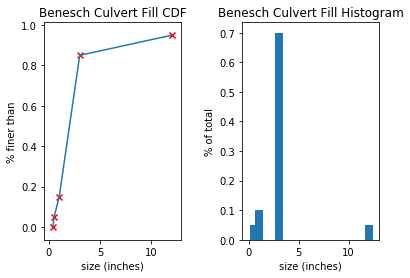

In [26]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2) #, sharey=True)

# Define data for plots
ax1.plot(data['size(inches)'], data['% finer than'])
ax1.scatter(data['size(inches)'], data['% finer than'], marker='x', color='r')
ax1.set_title('Benesch Culvert Fill CDF')
ax1.set(xlabel='size (inches)', ylabel='% finer than')

ax2.bar(data['size(inches)'], data['% of total'])
ax2.set_title('Benesch Culvert Fill Histogram')
ax2.set(xlabel='size (inches)', ylabel='% of total')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.45, hspace=None)
# ax3.bar(data['% of total'], data['size(inches)'])
# ax3.set_title('Draft Culvert fill sizing')
# ax3.set(xlabel='% of total', ylabel='size (inches)')
          
plt.show()
plt.close()

# B. Gold Run Culvert Data - dimensions, hydraulics

In [27]:
#Culvert ids
c_id = ['p-135', 
        'p-106', 
        'p-136', 
        'p-137', 
        'p-138', 
        'p-107', 
        'p-160', 
        'p-150', 
        'p-152',
        'p-153',
        'p-154',
        'p-139']

# Culvert Slopes
c_slope = [0.1, 
           0.1, 
           0.0679, 
           0.0618, 
           0.0707, 
           0.0536, 
           0.054, 
           0.0751, 
           0.0419,
           0.084,
           0.023,
           0.04]

# Culvert Hydrology (cfs flows)
c_bkfflow  =  [48,  48,  48,  48,  48,  48,  48,  48,  48,  48,  48,  48]
c_10yrflow =  [117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]
c_25yrflow =  [207, 207, 207, 203, 203, 203, 203, 203, 203, 203, 203, 203]

# Culvert flow top widths
c_bkfwidth  =  [5.9, 8, 7.2, 8, 6.0,  7, 8, 8, 8, 8, 8, 8]
c_10yrwidth =  [6.4, 8, 7.6, 8, 6.34, 7, 8, 8, 8, 8, 8, 8]
c_25yrwidth =  [6.4, 8, 7.6, 8, 6.34, 7, 8, 8, 8, 8, 8, 8]

# Culvert Velocities (greater of inlet or outlet conditions.  0 for culverts not modeled)
c_10yrvelocity = [7.16, 7.4, 5.34, 7, 6.14, 0, 0, 7, 7.66, 6.34, 7.16, 7.43]
# Impute missing values of culvert velocities, assume max velocity modeled at other locations
# print (c_10yrvelocity.isnull())

# Create Dataframe of culvert data
c_data = pd.DataFrame({'culvert id': c_id, 
                       'culvert_slope': c_slope,
                       'bkf flow (cfs)': c_bkfflow,  
                       '10yr flow (cfs)': c_10yrflow,
                       '25yr flow (cfs)': c_25yrflow, 
                       'bkf flow width (ft)': c_bkfwidth,  
                       '10yr flow width (ft)': c_10yrwidth,
                       '25yr flow width (ft)': c_25yrwidth})

# Arrange columns
cols = ['culvert id', 
        'culvert_slope', 
        'bkf flow (cfs)',  
        '10yr flow (cfs)', 
        '25yr flow (cfs)',
        'bkf flow width (ft)',  
        '10yr flow width (ft)',
        '25yr flow width (ft)']
c_data = c_data[cols]

c_data

,culvert id,culvert_slope,bkf flow (cfs),10yr flow (cfs),25yr flow (cfs),bkf flow width (ft),10yr flow width (ft),25yr flow width (ft)
0,p-135,0.1000,48,117,207,5.9,6.40,6.40
1,p-106,0.1000,48,117,207,8.0,8.00,8.00
2,p-136,0.0679,48,117,207,7.2,7.60,7.60
3,p-137,0.0618,48,117,203,8.0,8.00,8.00
4,p-138,0.0707,48,117,203,6.0,6.34,6.34
5,p-107,0.0536,48,117,203,7.0,7.00,7.00
6,p-160,0.0540,48,117,203,8.0,8.00,8.00
7,p-150,0.0751,48,117,203,8.0,8.00,8.00
8,p-152,0.0419,48,117,203,8.0,8.00,8.00
9,p-153,0.0840,48,117,203,8.0,8.00,8.00


# C. Riprap Sizing Calcs

## Method 1:  USACE
U.S. Army Corps of Engineers reference, EM 1110-2-1601, Section e., steep slope riprap design (Corps of Engineers. 1994)

### 1a. Add unit discharges to culvert data for 10 and 25 yr events

In [28]:
c_data['bkf unit discharge']  = c_data['bkf flow (cfs)']  /c_data['bkf flow width (ft)']
c_data['10yr unit discharge'] = c_data['10yr flow (cfs)'] /c_data['10yr flow width (ft)']    
c_data['25yr unit discharge'] = c_data['25yr flow (cfs)'] /c_data['25yr flow width (ft)']
    
c_data

,culvert id,culvert_slope,bkf flow (cfs),10yr flow (cfs),25yr flow (cfs),bkf flow width (ft),10yr flow width (ft),25yr flow width (ft),bkf unit discharge,10yr unit discharge,25yr unit discharge
0,p-135,0.1000,48,117,207,5.9,6.40,6.40,8.135593,18.281250,32.343750
1,p-106,0.1000,48,117,207,8.0,8.00,8.00,6.000000,14.625000,25.875000
2,p-136,0.0679,48,117,207,7.2,7.60,7.60,6.666667,15.394737,27.236842
3,p-137,0.0618,48,117,203,8.0,8.00,8.00,6.000000,14.625000,25.375000
4,p-138,0.0707,48,117,203,6.0,6.34,6.34,8.000000,18.454259,32.018927
5,p-107,0.0536,48,117,203,7.0,7.00,7.00,6.857143,16.714286,29.000000
6,p-160,0.0540,48,117,203,8.0,8.00,8.00,6.000000,14.625000,25.375000
7,p-150,0.0751,48,117,203,8.0,8.00,8.00,6.000000,14.625000,25.375000
8,p-152,0.0419,48,117,203,8.0,8.00,8.00,6.000000,14.625000,25.375000
9,p-153,0.0840,48,117,203,8.0,8.00,8.00,6.000000,14.625000,25.375000


### 1b. Compute recommended D30 using USACE method

In [29]:
# Create dataframe to hold results
sizing = pd.DataFrame(c_data['culvert id'])

# Define gravity constant
accel_gravity = 32.174

sizing['USACE_d30_bkf(in)'] = 12*((1.95 * c_data['culvert_slope']**(0.555)) * (1.25 * c_data['bkf unit discharge'])**(2/3) /  accel_gravity**(1/3))
sizing['USACE_d30_10yr(in)'] = 12*((1.95 * c_data['culvert_slope']**(0.555)) * (1.25 * c_data['10yr unit discharge'])**(2/3) /  accel_gravity**(1/3))
sizing['USACE_d30_25yr(in)'] = 12*((1.95 * c_data['culvert_slope']**(0.555)) * (1.25 * c_data['25yr unit discharge'])**(2/3) /  accel_gravity**(1/3))

# sizing['USACE_d30_25yr(in)'].mean()
sizing

,culvert id,USACE_d30_bkf(in),USACE_d30_10yr(in),USACE_d30_25yr(in)
0,p-135,9.621593,16.506618,24.146143
1,p-106,7.853954,14.224972,20.808515
2,p-136,6.796433,11.873810,17.369197
3,p-137,6.012941,10.890556,15.724982
4,p-138,7.848897,13.702917,19.785778
5,p-107,6.073459,11.000165,15.883248
6,p-160,5.579135,10.104852,14.590497
7,p-150,6.699903,12.134771,17.521517
8,p-152,4.846376,8.777689,12.674193
9,p-153,7.129570,12.912979,18.645179


### Creating  material size distribution based on d30:
The U.S. Army Corps of Engineers recommends angular rock with a uniform gradation (D85/D15 =2). This material is not preferred for use in a fish-passage structure (see the section on bed porosity, below). An approximate factor to scale D30 of a uniform riprap gradation for one that is
appropriate for stream channels is 1.5, so that, D84 = 1.5 * D30, where D84 is the dimension of the intermediate axis of the 84th percentile particle, and similarly for the 30th percentile.

### 1c. Determine d84 using USACE method

In [30]:
sizing['USACE_d84_bkf(in)'] = 1.5 * sizing['USACE_d30_bkf(in)']
sizing['USACE_d84_10yr(in)'] = 1.5 * sizing['USACE_d30_10yr(in)']
sizing['USACE_d84_25yr(in)'] = 1.5 * sizing['USACE_d30_25yr(in)']

sizing

,culvert id,USACE_d30_bkf(in),USACE_d30_10yr(in),USACE_d30_25yr(in),USACE_d84_bkf(in),USACE_d84_10yr(in),USACE_d84_25yr(in)
0,p-135,9.621593,16.506618,24.146143,14.432390,24.759927,36.219214
1,p-106,7.853954,14.224972,20.808515,11.780931,21.337458,31.212772
2,p-136,6.796433,11.873810,17.369197,10.194650,17.810715,26.053795
3,p-137,6.012941,10.890556,15.724982,9.019412,16.335833,23.587473
4,p-138,7.848897,13.702917,19.785778,11.773345,20.554375,29.678668
5,p-107,6.073459,11.000165,15.883248,9.110188,16.500247,23.824871
6,p-160,5.579135,10.104852,14.590497,8.368703,15.157278,21.885745
7,p-150,6.699903,12.134771,17.521517,10.049854,18.202157,26.282276
8,p-152,4.846376,8.777689,12.674193,7.269564,13.166534,19.011290
9,p-153,7.129570,12.912979,18.645179,10.694355,19.369468,27.967768


##  Method 2: CSU equations

Abt, S. R., et al. Development of riprap design criteria by riprap testing in flumes: Phase II, Followup investigations. No. NUREG/CR--4651-VOL. 2. Nuclear Regulatory Commission, 1988.
(prepared by S.R. Abt, et al, Colorado State University, 1988).

This method was developed for steep slopes from 2 to 20 percent. 

### 2a.  Determine the design unit discharge (eqn 7.1)
q' = q * Cf  
Where Cf = 1.0 for overland sheet flow,  
      Cf = 2.0 for a high probability of concentrated flow, and  
      Cf = 3.0 for a high probability of channelized flow 
      
For culvert fill, assume channelized flow - Cf=3.0

In [31]:
# Create a new dataframe for intermediate calculations of CSU method
csu = pd.DataFrame()

csu['CSU_bkf_qprime'] = 3.0 * c_data['bkf unit discharge']
csu['CSU_10yr_qprime'] = 3.0 * c_data['10yr unit discharge']
csu['CSU_25yr_qprime'] = 3.0 * c_data['25yr unit discharge']

csu

,CSU_bkf_qprime,CSU_10yr_qprime,CSU_25yr_qprime
0,24.406780,54.843750,97.031250
1,18.000000,43.875000,77.625000
2,20.000000,46.184211,81.710526
3,18.000000,43.875000,76.125000
4,24.000000,55.362776,96.056782
5,20.571429,50.142857,87.000000
6,18.000000,43.875000,76.125000
7,18.000000,43.875000,76.125000
8,18.000000,43.875000,76.125000
9,18.000000,43.875000,76.125000


### 2b. Estimate the median stone size (d50) of the riprap layer (eqn 7.2)
To size the median stone and prevent stone movement, adjust the design unit discharge by   
q** = 1.35 * q' 

In [32]:
csu['CSU_bkf_qstar'] = 1.35 * csu['CSU_bkf_qprime']
csu['CSU_10yr_qstar'] = 1.35 * csu['CSU_10yr_qprime']
csu['CSU_25yr_qstar'] = 1.35 * csu['CSU_25yr_qprime']

csu

,CSU_bkf_qprime,CSU_10yr_qprime,CSU_25yr_qprime,CSU_bkf_qstar,CSU_10yr_qstar,CSU_25yr_qstar
0,24.406780,54.843750,97.031250,32.949153,74.039062,130.992188
1,18.000000,43.875000,77.625000,24.300000,59.231250,104.793750
2,20.000000,46.184211,81.710526,27.000000,62.348684,110.309211
3,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750
4,24.000000,55.362776,96.056782,32.400000,74.739748,129.676656
5,20.571429,50.142857,87.000000,27.771429,67.692857,117.450000
6,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750
7,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750
8,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750
9,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750


### 2c. Determine d50 for angular stone (eqn 7.3)
d50 = 5.23 * slope^(0.43) * q*^(0.53)

In [33]:
csu['CSU_d50_bkf(in)'] = 5.23  * c_data['culvert_slope']**(0.43) * csu['CSU_bkf_qstar']**(0.53)
csu['CSU_d50_10yr(in)'] = 5.23  * c_data['culvert_slope']**(0.43) * csu['CSU_10yr_qstar']**(0.53)
csu['CSU_d50_25yr(in)'] = 5.23  * c_data['culvert_slope']**(0.43) * csu['CSU_25yr_qstar']**(0.53)

csu

,CSU_bkf_qprime,CSU_10yr_qprime,CSU_25yr_qprime,CSU_bkf_qstar,CSU_10yr_qstar,CSU_25yr_qstar,CSU_d50_bkf(in),CSU_d50_10yr(in),CSU_d50_25yr(in)
0,24.406780,54.843750,97.031250,32.949153,74.039062,130.992188,12.386800,19.024619,25.741968
1,18.000000,43.875000,77.625000,24.300000,59.231250,104.793750,10.540786,16.902606,22.870699
2,20.000000,46.184211,81.710526,27.000000,62.348684,110.309211,9.436881,14.704970,19.897107
3,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750,8.570340,13.742910,18.404037
4,24.000000,55.362776,96.056782,32.400000,74.739748,129.676656,10.576474,16.471547,22.058135
5,20.571429,50.142857,87.000000,27.771429,67.692857,117.450000,8.652659,13.874913,18.580810
6,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750,8.087277,12.968298,17.366703
7,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750,9.319620,14.944412,20.013048
8,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750,7.251453,11.628018,15.571846
9,18.000000,43.875000,76.125000,24.300000,59.231250,102.768750,9.779420,15.681722,21.000428


In [34]:
# Add results to sizing dataframe
sizing['CSU_d50_bkf(in)'] = csu['CSU_d50_bkf(in)']
sizing['CSU_d50_10yr(in)'] = csu['CSU_d50_10yr(in)']
sizing['CSU_d50_25yr(in)'] = csu['CSU_d50_25yr(in)']

sizing

,culvert id,USACE_d30_bkf(in),USACE_d30_10yr(in),USACE_d30_25yr(in),USACE_d84_bkf(in),USACE_d84_10yr(in),USACE_d84_25yr(in),CSU_d50_bkf(in),CSU_d50_10yr(in),CSU_d50_25yr(in)
0,p-135,9.621593,16.506618,24.146143,14.432390,24.759927,36.219214,12.386800,19.024619,25.741968
1,p-106,7.853954,14.224972,20.808515,11.780931,21.337458,31.212772,10.540786,16.902606,22.870699
2,p-136,6.796433,11.873810,17.369197,10.194650,17.810715,26.053795,9.436881,14.704970,19.897107
3,p-137,6.012941,10.890556,15.724982,9.019412,16.335833,23.587473,8.570340,13.742910,18.404037
4,p-138,7.848897,13.702917,19.785778,11.773345,20.554375,29.678668,10.576474,16.471547,22.058135
5,p-107,6.073459,11.000165,15.883248,9.110188,16.500247,23.824871,8.652659,13.874913,18.580810
6,p-160,5.579135,10.104852,14.590497,8.368703,15.157278,21.885745,8.087277,12.968298,17.366703
7,p-150,6.699903,12.134771,17.521517,10.049854,18.202157,26.282276,9.319620,14.944412,20.013048
8,p-152,4.846376,8.777689,12.674193,7.269564,13.166534,19.011290,7.251453,11.628018,15.571846
9,p-153,7.129570,12.912979,18.645179,10.694355,19.369468,27.967768,9.779420,15.681722,21.000428


## Material sizing method 3: USACE Traditional Ratios
From U.S. Army Corps of Engineers reference, EM 1110-2-1601, Section e., steep slope riprap design (Corps of Engineers. 1994), section 3-6

Some designers prefer to use the traditional D50 in riprap design. The approximate relationship  between D50 and D30 is D50 = D30 (D85/D15)^1/3. 
Rearrange to d15 = d85 / (d50/d30)^3

Note: working outside of suggested slope limits: Equation 3-3 can be used with either SI (metric) or non-SI units and should be limited to slopes less than 2 percent.

### 3a. Sizing d15

In [35]:
# Bankfull d15
sizing['USACE_d15_bkf(in)'] = sizing['USACE_d84_bkf(in)'] / ((sizing['CSU_d50_bkf(in)'] / sizing['USACE_d30_bkf(in)'])**3) 

# 10yr d15
sizing['USACE_d15_10yr(in)'] = sizing['USACE_d84_10yr(in)'] / ((sizing['CSU_d50_10yr(in)'] / sizing['USACE_d30_10yr(in)'])**3) 

# 25yr d15
sizing['USACE_d15_25yr(in)'] = sizing['USACE_d84_25yr(in)'] / ((sizing['CSU_d50_25yr(in)'] / sizing['USACE_d30_25yr(in)'])**3) 

sizing

,culvert id,USACE_d30_bkf(in),USACE_d30_10yr(in),USACE_d30_25yr(in),USACE_d84_bkf(in),USACE_d84_10yr(in),USACE_d84_25yr(in),CSU_d50_bkf(in),CSU_d50_10yr(in),CSU_d50_25yr(in),USACE_d15_bkf(in),USACE_d15_10yr(in),USACE_d15_25yr(in)
0,p-135,9.621593,16.506618,24.146143,14.432390,24.759927,36.219214,12.386800,19.024619,25.741968,6.763972,16.172448,29.892144
1,p-106,7.853954,14.224972,20.808515,11.780931,21.337458,31.212772,10.540786,16.902606,22.870699,4.873328,12.718503,23.508086
2,p-136,6.796433,11.873810,17.369197,10.194650,17.810715,26.053795,9.436881,14.704970,19.897107,3.808290,9.376897,17.331670
3,p-137,6.012941,10.890556,15.724982,9.019412,16.335833,23.587473,8.570340,13.742910,18.404037,3.114906,8.129340,14.713384
4,p-138,7.848897,13.702917,19.785778,11.773345,20.554375,29.678668,10.576474,16.471547,22.058135,4.811750,11.834234,21.418914
5,p-107,6.073459,11.000165,15.883248,9.110188,16.500247,23.824871,8.652659,13.874913,18.580810,3.150553,8.222374,14.881768
6,p-160,5.579135,10.104852,14.590497,8.368703,15.157278,21.885745,8.087277,12.968298,17.366703,2.747589,7.170710,12.978350
7,p-150,6.699903,12.134771,17.521517,10.049854,18.202157,26.282276,9.319620,14.944412,20.013048,3.733969,9.744984,17.637556
8,p-152,4.846376,8.777689,12.674193,7.269564,13.166534,19.011290,7.251453,11.628018,15.571846,2.170124,5.663632,10.250672
9,p-153,7.129570,12.912979,18.645179,10.694355,19.369468,27.967768,9.779420,15.681722,21.000428,4.143863,10.814731,19.573704


# D. Comparing Results
## Reshaping for plotting

In [36]:
# Clean up each flow rate data
sizing_bkf = pd.DataFrame({'d15': sizing.loc[:,'USACE_d15_bkf(in)'],  
                           'd30': sizing.loc[:,'USACE_d30_bkf(in)'],  
                           'd50': sizing.loc[:,'CSU_d50_bkf(in)'],
                           'd84': sizing.loc[:,'USACE_d84_bkf(in)'],  
                           'flow': 'bankfull'
                          })

sizing_10yr = pd.DataFrame({'d15': sizing.loc[:,'USACE_d15_10yr(in)'],  
                           'd30': sizing.loc[:,'USACE_d30_10yr(in)'],  
                           'd50': sizing.loc[:,'CSU_d50_10yr(in)'],
                           'd84': sizing.loc[:,'USACE_d84_10yr(in)'],  
                            'flow': '10yr'
                          })

sizing_25yr = pd.DataFrame({'d15': sizing.loc[:,'USACE_d15_25yr(in)'],  
                           'd30': sizing.loc[:,'USACE_d30_25yr(in)'],  
                           'd50': sizing.loc[:,'CSU_d50_25yr(in)'],
                           'd84': sizing.loc[:,'USACE_d84_25yr(in)'],  
                            'flow': '25yr'
                          })

# Reconcatenate into single dataframe
frames = [sizing_bkf, sizing_10yr, sizing_25yr]
riprap = pd.concat(frames)

# Reset index to flow
riprap = riprap.set_index('flow')
riprap['flow'] = riprap.index


riprap


,d15,d30,d50,d84,flow
flow,,,,,
bankfull,6.763972,9.621593,12.386800,14.432390,bankfull
bankfull,4.873328,7.853954,10.540786,11.780931,bankfull
bankfull,3.808290,6.796433,9.436881,10.194650,bankfull
bankfull,3.114906,6.012941,8.570340,9.019412,bankfull
bankfull,4.811750,7.848897,10.576474,11.773345,bankfull
bankfull,3.150553,6.073459,8.652659,9.110188,bankfull
bankfull,2.747589,5.579135,8.087277,8.368703,bankfull
bankfull,3.733969,6.699903,9.319620,10.049854,bankfull
bankfull,2.170124,4.846376,7.251453,7.269564,bankfull


# Create new dataframe with basic stats

In [37]:
riprap_desc_bkf = riprap.loc['bankfull',:].describe()
riprap_desc_10yr = riprap.loc['10yr',:].describe()
riprap_desc_25yr = riprap.loc['25yr',:].describe()

riprap_desc_bkf

,d15,d30,d50,d84
count,12.000000,12.000000,12.000000,12.000000
mean,3.553260,6.388296,8.942736,9.582444
std,1.492818,1.653816,1.821727,2.480724
min,1.242317,3.474140,5.602940,5.211210
25%,2.603223,5.395945,7.878321,8.093918
50%,3.442261,6.386681,8.986139,9.580021
75%,4.310834,7.309402,9.969762,10.964103
max,6.763972,9.621593,12.386800,14.432390


In [38]:
# mean_bkf  = np.array(riprap_desc_bkf.loc['mean',:])
# mean_10yr = np.array(riprap_desc_10yr.loc['mean',:])
# mean_25yr = np.array(riprap_desc_25yr.loc['mean',:])

mean_bkf = np.array(riprap.loc['bankfull',:].mean())
mean_10yr = np.array(riprap.loc['10yr',:].mean())
mean_25yr = np.array(riprap.loc['25yr',:].mean())

mean_25yr

array([ 16.48933896,  16.54889284,  19.06673218,  24.82333926])

### Note: Sizing for riprap distribution was calculated from the average of 13 culvert conditions across the project

## Plotting design mix

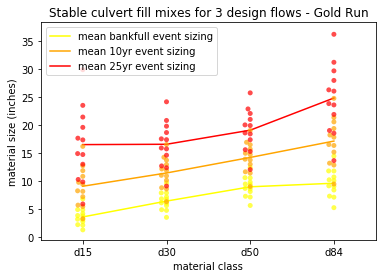

In [111]:
import seaborn as sns

# Plot individual culvert fill sizing results
sns.swarmplot(data=riprap.loc['bankfull',:], color='yellow',alpha=.7)
sns.swarmplot(data=riprap.loc['10yr',:], color='orange', alpha = .7)
sns.swarmplot(data=riprap.loc['25yr',:], color='red', alpha = .7)

# Plot the mean culvert fill sizing for the job
plt.plot(mean_bkf, color='yellow', label='mean bankfull event sizing')
plt.plot(mean_10yr, color='orange', label='mean 10yr event sizing')
plt.plot(mean_25yr, color='red', label ='mean 25yr event sizing')

# Add labels, title, and legend
plt.ylabel('material size (inches)')
plt.xlabel('material class')
plt.legend(loc='upper left')
plt.title('Stable culvert fill mixes for 3 design flows - Gold Run')

plt.show()


## Determining Fill Depth
Determining average depth for culvert fill.  Using calculated riprap sizing distributions to ensure average fill depth is less than or equal to 6" for hydraulic capacity. An alternative method would be to simply specify 2*d50.

In [40]:
# filldepth_bkf  = pd.DataFrame(riprap_desc_bkf.loc['mean',:])
# filldepth_10yr = pd.DataFrame(riprap_desc_10yr.loc['mean',:])
# filldepth_25yr = pd.DataFrame(riprap_desc_25yr.loc['mean',:])

In [41]:
# Create function for determining average depth from distribution
def average_depth(array):
    print (array)
    
average_depth(mean_bkf)

[ 3.55326006  6.38829591  8.94273649  9.58244386]


In [42]:
filldepth_bkf = pd.DataFrame(riprap_desc_bkf.loc['mean',:])

# Add column of percent finer than
filldepth_bkf['pct_finer'] = [15,30,50,84]

# Add percent of total column
filldepth_bkf['% of total'] = 0

# Calculate % of total field
for i in range(len(filldepth_bkf)):
    if i == 0:
        filldepth_bkf['% of total'].iloc[i] = filldepth_bkf['pct_finer'].iloc[i] - 0
    if 4>i>0:
        filldepth_bkf['% of total'].iloc[i] = filldepth_bkf['pct_finer'].iloc[i] - filldepth_bkf['pct_finer'].iloc[i-1]
    if i==4:
        filldepth_bkf['% of total'].iloc[i] = 100 - (filldepth_bkf['pct_finer'].iloc[i])

# Calculate the weighted depth based on size and % of total
filldepth_bkf['weighted_depth (inches)'] = filldepth_bkf['mean'] * (filldepth_bkf['% of total']/100)
        
filldepth_bkf

,mean,pct_finer,% of total,weighted_depth (inches)
d15,3.553260,15,15,0.532989
d30,6.388296,30,15,0.958244
d50,8.942736,50,20,1.788547
d84,9.582444,84,34,3.258031


In [43]:
print ('Average fill depth for bankfull flow mix: %2f inches' % (filldepth_bkf['weighted_depth (inches)'].sum()))

Average fill depth for bankfull flow mix: 6.537812 inches


# E. Evaluating Culvert Fill Mix
Hydraulic considerations and the original culvert designs limit the final depth of riprap on aprons.  A riprap mix that is stable at bankfull is likely the largest mix that can be used while attaining hydraulic capacity.  The histogram of the bankfull mix is below

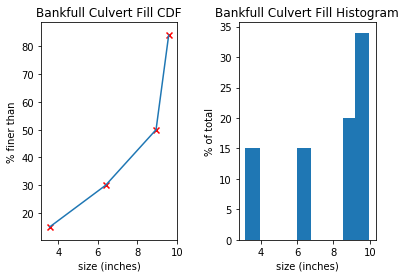

In [44]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2) #, sharey=True)

# Define data for plots
ax1.plot(filldepth_bkf['mean'], filldepth_bkf['pct_finer'])
ax1.scatter(filldepth_bkf['mean'], filldepth_bkf['pct_finer'], marker='x', color='r')
ax1.set_title('Bankfull Culvert Fill CDF')
ax1.set(xlabel='size (inches)', ylabel='% finer than')

ax2.bar(filldepth_bkf['mean'], filldepth_bkf['% of total'])
ax2.set_title('Bankfull Culvert Fill Histogram')
ax2.set(xlabel='size (inches)', ylabel='% of total')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.45, hspace=None)
          
plt.show()
plt.close()

In [46]:
# Additional Resources

# Urban Drainage Constructed Channels
# https://udfcd.org/wp-content/uploads/uploads/resources/technical%20papers/Combined%20VFR%20paper%20and%20appendices%204-21-11.pdf

# Q-Q plots
# https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot
# https://data.library.virginia.edu/understanding-q-q-plots/

In [121]:
# UDFCD riprap gradation
udfcd_sizing = [15, 12, 9, 3]
udfcd_percentile = [100, 70, 50, 10]

typeL = pd.DataFrame({'udfcd_sizing(in)': udfcd_sizing,
                     'udfcd_percentile': udfcd_percentile})
                     
typeL

,udfcd_percentile,udfcd_sizing(in)
0,100,15
1,70,12
2,50,9
3,10,3


## Compare distributions of design mix to closest UDFCD riprap mix

In [159]:
# Define quantiles from bankfull mix as 'x'
design_ptiles = filldepth_bkf['pct_finer'].values
# Define quantiles from UDFCD riprap gradations
udfcd_ptiles = np.sort(typeL['udfcd_percentile'])

print ("design mix percentiles: %s UDFCD mix percentiles: %s" % (design_ptiles, udfcd_ptiles))

design mix percentiles: [15 30 50 84] UDFCD mix percentiles: [ 10  50  70 100]


In [167]:
# Interpolate the missing percentiles values in UDFCD to match design mix percentiles
# https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.interp.html

udfcd_vals = 1.0*(np.sort(typeL['udfcd_sizing(in)']))
# print (udfcd_vals)

udfcd_interp_vals = np.interp(design_ptiles, udfcd_ptiles, udfcd_vals)
print ("UDFCD interpolated sizes:", udfcd_interp_vals)

UDFCD interpolated sizes: [  3.75   6.     9.    13.4 ]


In [169]:
# from scipy.interpolate import interp1d
# x = np.linspace(0, 10, num=11, endpoint=True)
# y = np.cos(-x**2/9.0)
# f = interp1d(x, y)
# f2 = interp1d(x, y, kind='cubic')

# print (x)
# print (y)
# print (f)
# print (f2)

# xnew = np.linspace(0, 10, num=41, endpoint=True)
# import matplotlib.pyplot as plt
# plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
# plt.legend(['data', 'linear', 'cubic'], loc='best')
# plt.show()


[ 3.55326006  6.38829591  8.94273649  9.58244386] [  3.75   6.     9.    13.4 ]


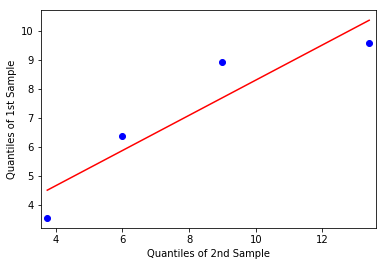

In [183]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

# x = np.percentile(filldepth_bkf['mean'],filldepth_bkf['pct_finer'])
# y = np.percentile(typeL['udfcd_sizing'], typeL['udfcd_percentile'])

print (filldepth_bkf['mean'].values, udfcd_interp_vals)

pp_x = sm.ProbPlot(filldepth_bkf['mean'].values)
pp_y = sm.ProbPlot(udfcd_interp_vals)
sm.qqplot_2samples(pp_x, pp_y, line='r')
